Описание задания:
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.

Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

1. Инсталлируйте библиотеку opencv, если не делали это ранее

In [67]:
import numpy as np
import sklearn

print(np.__version__)
print(sklearn.__version__)

1.23.5
1.7.0


In [68]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim

2. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

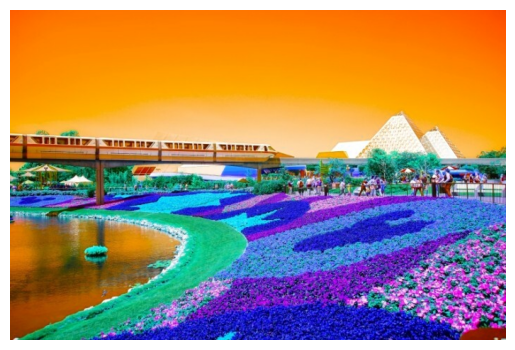

In [69]:
# Посмотрим на картинку без преобразования из BGR в RGB
image = cv2.imread('feml.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

* Для отображения картинки воспользуйтесь вспомогательной функцией:

In [70]:
# Теперь обработаем цветовое пространство с использованием функции draw_picture с преобразованием формата BGR в RGB
def draw_picture(image, title, bgr=True):
    if bgr:
        b, g, r = cv2.split(image)
        image = cv2.merge([r, g, b])

    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [71]:
img = cv2.imread('feml.jpg')
original_shape = img.shape[:2]  

In [72]:
original_shape # строки (высота), столбцы (ширина)

(466, 700)

3. Реализуйте три модели кластеризации:
* KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.
* DBSCAN
* AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

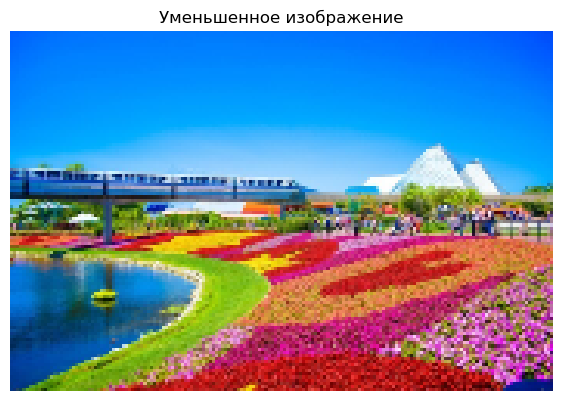

In [73]:
# Уменьшаем изображение для ускорения обработки (AgglomerativeClustering самая тяжелая модель, поэтому подберем 0.25)
scale_factor = 0.25
small_img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)

# Визуализация уменьшенного изображения
draw_picture(small_img, 'Уменьшенное изображение', bgr=True)

In [74]:
# Размеры уменьшенного изображения
small_shape = small_img.shape
small_shape

(116, 175, 3)

In [75]:
# Размеры исходного изображения
original_shape = img.shape
original_shape

(466, 700, 3)

In [76]:
# Преобразуем изображение в массив пикселей
pixel_values = small_img.reshape((-1, 3))
pixel_values

array([[254,  93,   0],
       [254,  95,   0],
       [253,  95,   0],
       ...,
       [120,  24,   1],
       [117,  26,   3],
       [100,  26,  11]], dtype=uint8)

In [77]:
pixel_values.shape[0]

20300

In [78]:
# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pixel_values)

In [79]:
# Зададим число кластеров
k_values = [2, 5, 10, 20]

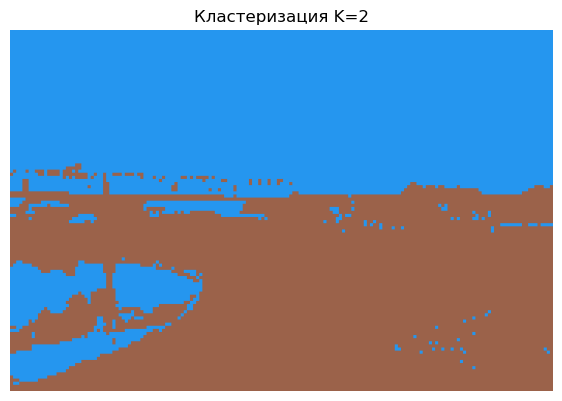

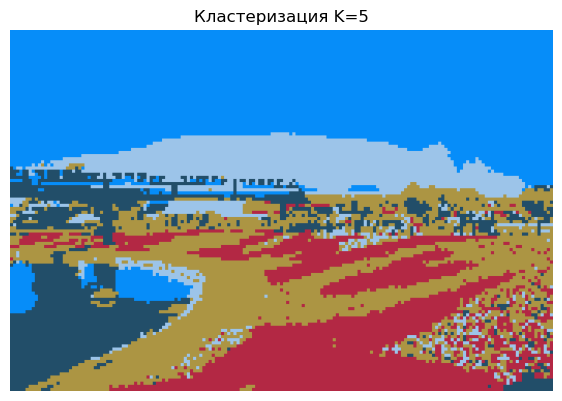

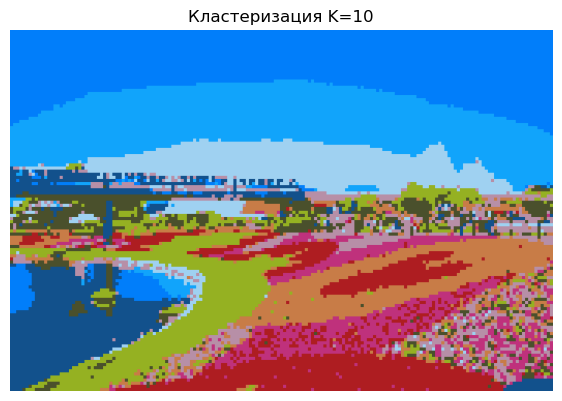

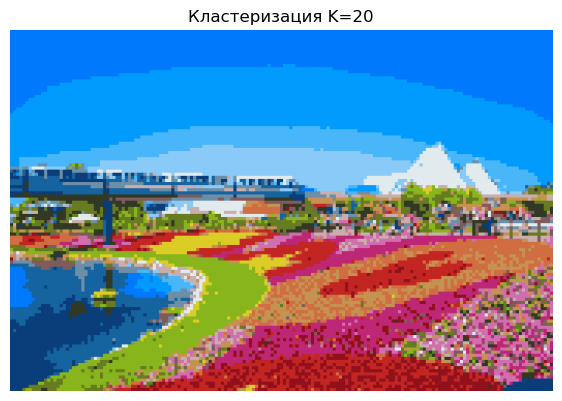

In [80]:
for K in k_values:
    kmeans = KMeans(n_clusters=K, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Возвращаем центры кластеров в исходные цветовые значения и приводим к формату 0-255
    centers_unscaled = scaler.inverse_transform(kmeans.cluster_centers_).astype(np.uint8)
    
    # На каждый элемент накладываем метку кластера
    segmented_pixels = centers_unscaled[labels]
    
    # Восстановление в формат (H, W, 3) изображения в уменьшенной версии
    segmented_img_small = segmented_pixels.reshape(small_img.shape).astype(np.uint8)
    
    # В формате исходных размеров
    segmented_img_full_size = cv2.resize(segmented_img_small, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
    
    draw_picture(segmented_img_full_size, f'Кластеризация K={K}', bgr=True)

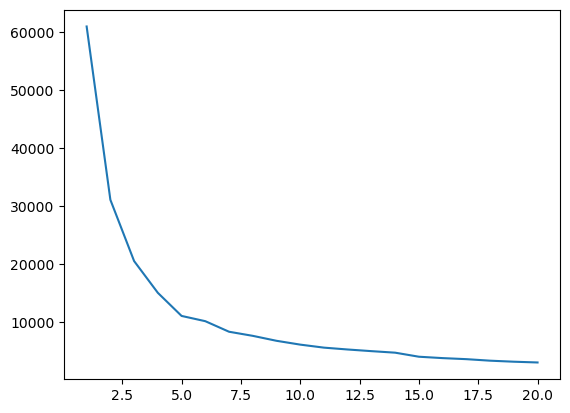

In [81]:
# Метод локтя
k_inertia = []
ks = range(1,21)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k, random_state=42)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled)
    k_inertia.append(clf_kmeans.inertia_)

plt.plot(ks, k_inertia)

In [82]:
# DBSCAN
print('Min scaled:', X_scaled.min(axis=0))
print('Max scaled:', X_scaled.max(axis=0))

Min scaled: [-1.71229376 -2.27681697 -1.09018819]
Max scaled: [1.02354687 2.3516558  1.85309305]


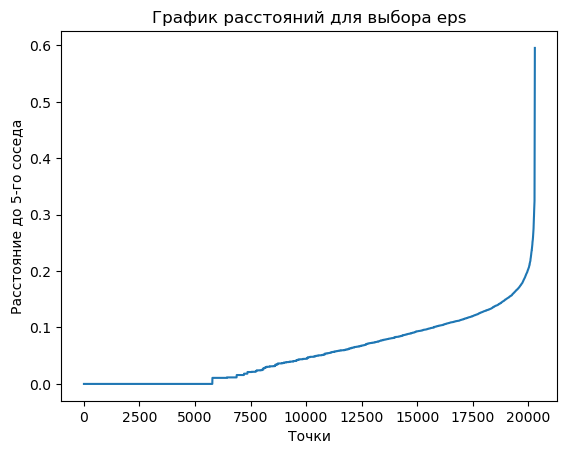

In [83]:
# Ближайших соседей
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

k_distances = np.sort(distances[:, -1])

plt.plot(k_distances)
plt.ylabel('Расстояние до 5-го соседа')
plt.xlabel('Точки')
plt.title('График расстояний для выбора eps')
plt.show()

In [84]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Кластеры: {n_clusters}, Шум: {n_noise}')

Кластеры: 3, Шум: 129


In [85]:
dbscan = DBSCAN(eps=0.15, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Кластеры: {n_clusters}, Шум: {n_noise}')

Кластеры: 22, Шум: 580


In [86]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Кластеры: {n_clusters}, Шум: {n_noise}')

Кластеры: 166, Шум: 2993


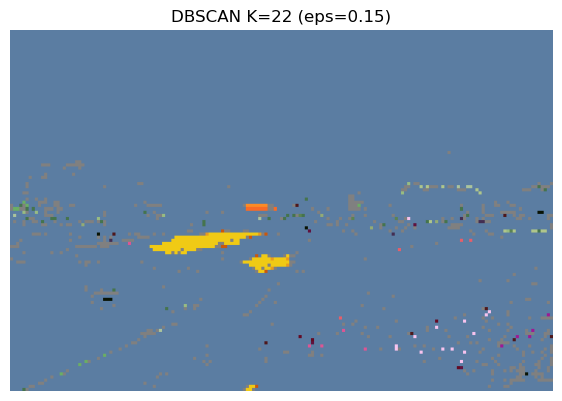

In [87]:
eps_value = 0.15 

dbscan = DBSCAN(eps=eps_value, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Обработка меток
segmented_pixels = np.zeros_like(pixel_values)

unique_labels = set(labels)
for label in unique_labels:
    mask = (labels == label)
    if label == -1:
        segmented_pixels[mask] = [128, 128, 128]  # серый цвет для шумовых точек
    else:
        mean_color = pixel_values[mask].mean(axis=0)
        segmented_pixels[mask] = mean_color

K = len(set(labels)) - (1 if -1 in labels else 0)

segmented_img_small = segmented_pixels.reshape(small_img.shape).astype(np.uint8)
segmented_img_full_size = cv2.resize(segmented_img_small,
                                     (original_shape[1], original_shape[0]),
                                     interpolation=cv2.INTER_NEAREST)

draw_picture(segmented_img_full_size,
             f'DBSCAN K={K} (eps={eps_value})', bgr=True)

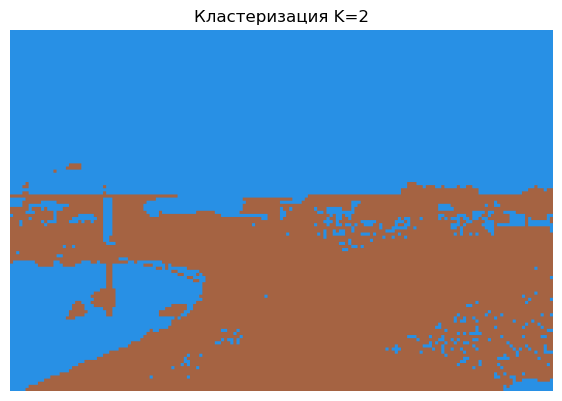

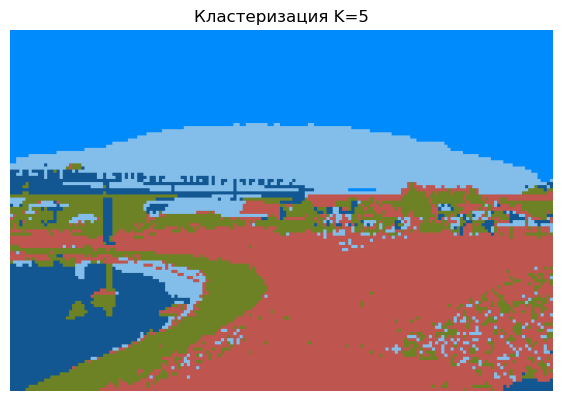

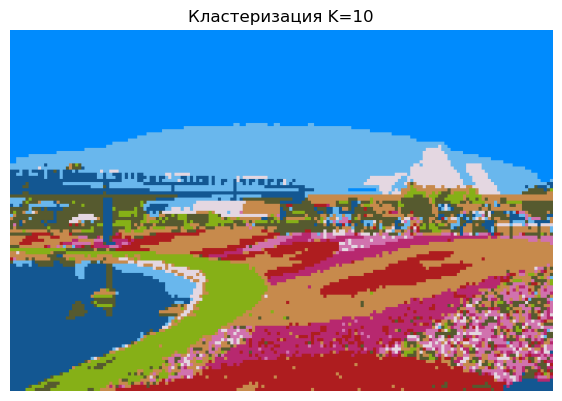

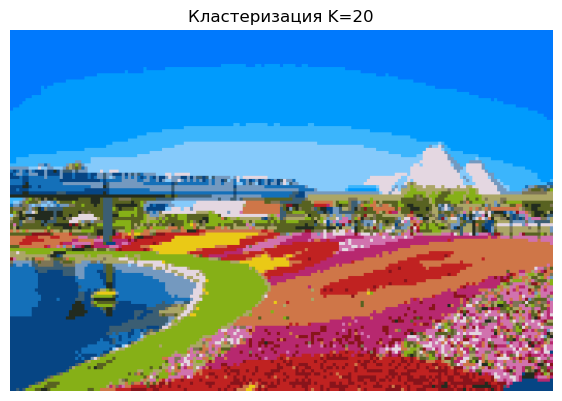

In [88]:
# AgglomerativeClustering
for K in k_values:
    clustering = AgglomerativeClustering(n_clusters=K)
    labels = clustering.fit_predict(pixel_values)

    segmented_pixels = np.zeros_like(pixel_values)
    
    # Определяем средний цвет по кластеру
    for cluster_id in range(K):
        mask = (labels == cluster_id)
        mean_color = pixel_values[mask].mean(axis=0)
        segmented_pixels[mask] = mean_color

    segmented_img_small = segmented_pixels.reshape(small_shape).astype(np.uint8)
    full_size_segmented_img = cv2.resize(segmented_img_small, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
    
    draw_picture(full_size_segmented_img, f'Кластеризация K={K}', bgr=True)

4. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.
После выполнения алгоритма кластеризации каждый пиксель изображения принадлежит своему классу. Вы можете выбрать любой вариант преобразования изображения:
* Покрасить все пиксели одного класса в средний цвет;
* Покрасить все пиксели одного класса в медианный цвет;
* Покрасить все пиксели одного класса в цвет центрального пикселя данного класса (для алгоритмов, в которых это актуально).
Важно, что после такого преобразования кластеризованное изображение совпадает по размерностям с исходным: (height, width, 3)

In [89]:
# Визуализация уменьшенного изображения
height, width = small_img.shape[:2]
img_rgb = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)
pixels = img_rgb.reshape(-1, 3)

# Замена цвета по кластеру
def replace_cluster_colors(labels, method='mean'):
    new_pixels = np.zeros_like(pixels)
    for cluster_id in np.unique(labels):
        mask = (labels == cluster_id)
        cluster_pixels = pixels[mask]
        if method == 'mean':
            color = cluster_pixels.mean(axis=0)
        elif method == 'median':
            color = np.median(cluster_pixels, axis=0)
        elif method == 'center':
            center_idx = len(cluster_pixels) // 2
            color = cluster_pixels[center_idx]
        else:
            raise ValueError('Error')
        new_pixels[mask] = color
    return new_pixels

results = []

# KMeans
kmeans = KMeans(n_clusters=8, random_state=42).fit(pixels)
labels_kmeans = kmeans.labels_
for method in ['mean', 'median', 'center']:
    replaced_pixels = replace_cluster_colors(labels_kmeans, method=method)
    img_replaced = replaced_pixels.reshape((height, width, 3)).astype(np.uint8)
    ssim_value = ssim(img_rgb, img_replaced, multichannel=True, win_size=3)
    results.append(('KMeans', method, ssim_value))

# DBSCAN
dbscan = DBSCAN(eps=10, min_samples=50).fit(pixels)
labels_dbscan = dbscan.labels_
for method in ['mean', 'median', 'center']:
    replaced_pixels = replace_cluster_colors(labels_dbscan, method=method)
    img_replaced = replaced_pixels.reshape((height, width, 3)).astype(np.uint8)
    ssim_value = ssim(img_rgb, img_replaced, multichannel=True, win_size=3)
    results.append(('DBSCAN', method, ssim_value))

# AgglomerativeClustering
aggl = AgglomerativeClustering(n_clusters=8).fit(pixels)
labels_aggl = agglo.labels_
for method in ['mean', 'median', 'center']:
    replaced_pixels = replace_cluster_colors(labels_aggl, method=method)
    img_replaced = replaced_pixels.reshape((height, width, 3)).astype(np.uint8)
    ssim_value = ssim(img_rgb, img_replaced, multichannel=True, win_size=3)
    results.append(('Agglomerative', method, ssim_value))

for model_name, color_method, ssim_score in results:
    print(f'{model_name} + {color_method} color: SSIM={ssim_score:.4f}')

KMeans + mean color: SSIM=0.9045
KMeans + median color: SSIM=0.9041
KMeans + center color: SSIM=0.8533
DBSCAN + mean color: SSIM=0.6675
DBSCAN + median color: SSIM=0.6791
DBSCAN + center color: SSIM=0.6778
Agglomerative + mean color: SSIM=0.8863
Agglomerative + median color: SSIM=0.8893
Agglomerative + center color: SSIM=0.8480


5. Сформулируйте выводы по проделанной работе.
* Какая модель показала лучший результат?

Самый высокий результат KMeans + mean color: SSIM=0.9045, KMeans + median color: SSIM=0.9041.
KMeans + center color: SSIM=0.8533 чуть хуже.

DBSCAN в целом показал худший результат, что видно по визуализации.